In [52]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# MACHINE LEARNING
from sklearn.model_selection import train_test_split, learning_curve
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
## Hyperparameter Tuning
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit

# PROJECT MODULES
import models_utils

In [53]:
## HYPERPARAMETER TUNING

def perform_search(model, params, X_train, y_train, X_test, y_test, search_type='random'):
    tscv = TimeSeriesSplit(n_splits=3)
    
    if search_type == 'random':
        search = RandomizedSearchCV(model, param_distributions=params, n_iter=200, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, cv=tscv)
    elif search_type == 'grid':
        search = GridSearchCV(model, param_grid=params, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, cv=tscv)
    else:
        raise ValueError("Invalid search_type. Use 'random' or 'grid'.")
    
    model_search = search.fit(X_train, y_train)

    print('Best hyperparameters are: ' + str(model_search.best_params_))
    print('Best score is: ' + str(model_search.best_score_))

    model = model_search.best_estimator_
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)
    print('MSE:', mse)
    print('MAE:', mae)
    print('MAPE:', mape)
    
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_percentage_error')

    return model, train_sizes, train_scores, test_scores

In [54]:
## CHARTS and UTILS

tscv = TimeSeriesSplit(n_splits=3)

def get_model_feature_importances(model, feature_names):
    feature_importances = model.feature_importances_
    feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances_df.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances_df.set_index('feature', inplace=True, drop=True)
    return feature_importances_df


def plot_learning_curve(model, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    plt.xlabel('Training examples')
    plt.ylabel(f'Negative {scoring.capitalize()}')  # Adjust the ylabel based on your scoring metric
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()

def plot_feature_importances(feature_importances, feature_names):
    # Sort feature importances in descending order
    sorted_idx = np.argsort(feature_importances)[::-1]
    # Plot the top 20 most important features
    plt.figure(figsize=(10, 6))
    plt.bar(range(20), feature_importances[sorted_idx][:20], align='center')
    plt.xticks(range(20), feature_names[sorted_idx][:20], rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

def remove_low_importance_features(feature_importances, threshold=0.01):
    # Assuming feature_importances is a pandas Series
    selected_features = feature_importances[feature_importances >= threshold].index
    return selected_features

In [55]:
## OPEN FILE

lots = pd.read_csv('../clean-files/catalogo_artworks_info.csv', index_col=0)
lots.drop(columns=['Error', '0', '0.1', '0.2', '0.3', '0.4'], inplace=True)

# Fix Year Column
# lots['Year'] = lots.index
# lots['Year'] = lots['Year'].astype(float).astype(int)
# lots['Year'] = lots['Year'].fillna(lots['Década'])
# lots['Year'] = lots['Year'].fillna(lots['Year'].mean())
# lots['Year'] = lots['Year'].astype(int)

print(lots.shape)
lots.columns

(22265, 21)


Index(['artist_link', 'Descrição', 'Fonte de Pesquisa', 'Data da Pesquisa',
       'Type', 'Século', 'Artist', 'Título', 'url', 'Década', 'img_url',
       'Medium', 'Height (cm)', 'Width (cm)', 'Area (cm²)', 'Price (BRL)',
       'Price (USD)', 'Price (BRL/cm²)', 'Medium_type', 'Sold',
       'Year of sale'],
      dtype='object')

In [56]:
## SELECT ARTISTS

artists = lots['Artist'].value_counts()
artists = artists[artists > 500]
print(artists)
artists = artists.index
lots = lots[lots['Artist'].isin(artists)]

Artist
Di Cavalcanti (1897-1976)                                     2937
Aldemir Martins                                               2257
Candido Portinari (1903-1962)                                 2008
Milton Dacosta                                                1908
Antônio Bandeira (1922-1967)                                  1703
Tarsila do Amaral                                             1478
Djanira da Motta e Silva                                      1368
Alberto Guignard - Alberto da Veiga Guignard                  1081
Maria Leontina Franco Da Costa                                1074
Ibere Camargo - Iberê Camargo                                 1039
José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti    1035
Cicero Dias - Cícero Dias                                      606
Cildo Meireles (1948)                                          606
Alfredo Volpi                                                  587
Annita Catarina Malfatti - Anita Malfatti - Anita Malfa

In [57]:
## DROP OUTLIERS (BRL/cm² > 0.9 percentile and < 0.1 percentile)

# for each medium_type, remove outliers: lots with price / area > 0.9 percentile
for medium_type in lots['Medium_type'].unique():
    medium_type_lots = lots[lots['Medium_type'] == medium_type]
    medium_type_lots = medium_type_lots[medium_type_lots['Price (BRL/cm²)'] < medium_type_lots['Price (BRL/cm²)'].quantile(0.8)]
    medium_type_lots = medium_type_lots[medium_type_lots['Price (BRL/cm²)'] > medium_type_lots['Price (BRL/cm²)'].quantile(0.2)]
    print(medium_type, len(medium_type_lots))
    lots = pd.concat([lots[lots['Medium_type'] != medium_type], medium_type_lots])

desenho 2704
reprodução 2995
pintura 6559
outro 905


In [58]:
## DISCARD 'OTHER' MEDIUM TYPES
rlots = lots[lots['Medium_type'] != 'outro']
# lots = lots[lots['Medium_type'] == 'pintura']

In [59]:
## GET DF TO MODEL
lots = lots[['Artist', 'Width (cm)', 'Height (cm)', 'Year of sale', 'Price (BRL)', 'Medium_type']]
X_train, X_test, y_train, y_test = models_utils.get_df_to_model(lots)

feature_names = X_train.columns

shape of lots_to_model (before split): (13163, 6)
model features: 21


In [60]:
# Random Forest
rf = RandomForestRegressor()
rf_params = {
    'n_estimators': np.arange(10, 110, step=20),
     'max_depth': np.arange(2, 10, step=1),
     'min_samples_split': np.arange(2, 10, step=1),
     'min_samples_leaf': np.arange(2, 10, step=1),
}

rf_model, rf_train_sizes, rf_train_scores, rf_test_scores = perform_search(rf, rf_params, X_train, y_train, X_test, y_test, search_type='random')
rf_feature_importances = rf_model.feature_importances_

plot_learning_curve(rf_model, X_train, y_train, cv=tscv)
rf_feature_importances_df = get_model_feature_importances(rf_model, feature_names)
rf_feature_importances_df

In [ ]:
## Better setup so far (removed outliers and medium_type == 'outro', artists with > 300 lots)

# Best hyperparameters are: {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 9}
# Best score is: -776975725.5247191
# MSE: 1213232227.0454812
# MAE: 8760.363494589017
# MAPE: 0.4852745256498374

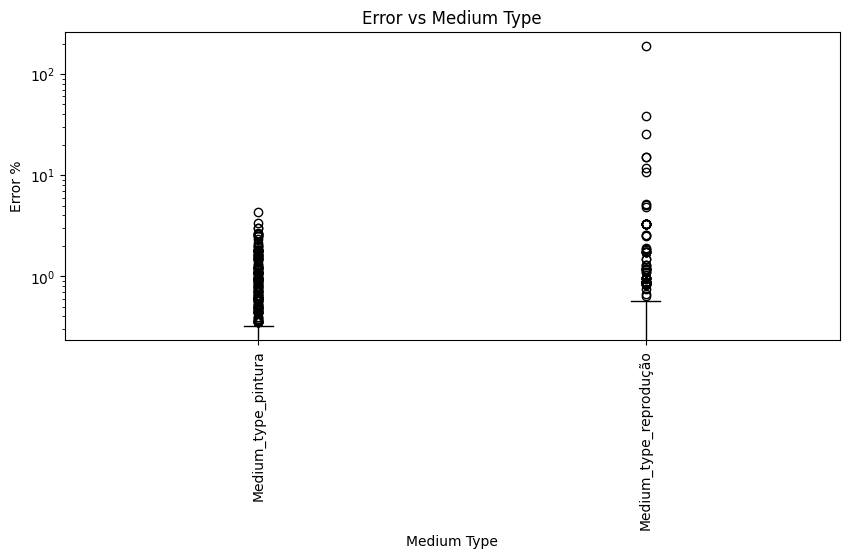

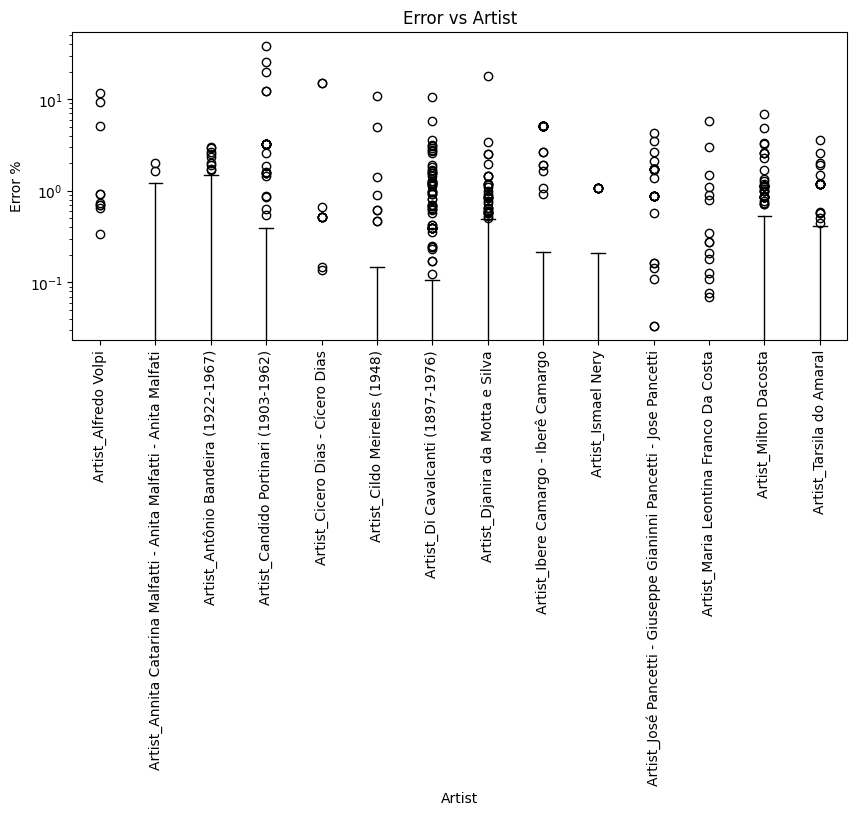

In [ ]:
lots_copy = models_utils.get_predicted_price_and_error(X_test, y_test, rf_model)
medium_types = ['Medium_type_pintura', 'Medium_type_reprodução'] #, 'desenho']
artists = lots_copy.columns[1:-10]

models_utils.plot_error_by_columns(lots_copy, medium_types, 'Medium Type')
models_utils.plot_error_by_columns(lots_copy, artists, 'Artist')

In [ ]:
## Analyse lots with highest error

lots_copy.sort_values(by='Error %', ascending=False, inplace=True)
lots_copy.head(10)

,Artist_Aldemir Martins,Artist_Alfredo Volpi,Artist_Annita Catarina Malfatti - Anita Malfatti - Anita Malfati,Artist_Antônio Bandeira (1922-1967),Artist_Candido Portinari (1903-1962),Artist_Cicero Dias - Cícero Dias,Artist_Cildo Meireles (1948),Artist_Di Cavalcanti (1897-1976),Artist_Djanira da Motta e Silva,Artist_Ibere Camargo - Iberê Camargo,...,Height (cm),Medium_type_outro,Medium_type_pintura,Medium_type_reprodução,Width (cm),Year of sale,Predicted Price,Actual Price,Error,Error %
Year,,,,,,,,,,,,,,,,,,,,,
NaN,True,False,False,False,False,False,False,False,False,False,...,100.0,False,False,True,148.00,2018,766457.660579,4000.0,762457.660579,189.614415
NaN,False,False,False,False,True,False,False,False,False,False,...,109.0,False,False,True,127.00,2013,121686.816190,3000.0,118686.816190,38.562272
1941.0,False,False,False,False,True,False,False,False,False,False,...,112.0,False,False,True,137.50,2015,270751.081278,9800.0,260951.081278,25.627661
1941.0,False,False,False,False,True,False,False,False,False,False,...,100.0,True,False,False,140.00,2016,436094.240861,20000.0,416094.240861,19.804712
NaN,False,False,False,False,False,False,False,False,True,False,...,93.0,True,False,False,1.38,2008,50237.660161,2500.0,47737.660161,18.095064
NaN,False,False,False,False,False,True,False,False,False,False,...,72.0,False,False,True,95.00,2022,29149.683366,1700.0,27449.683366,15.146873
NaN,False,False,False,False,False,True,False,False,False,False,...,72.0,False,False,True,95.00,2022,29149.683366,1700.0,27449.683366,15.146873
NaN,False,False,False,False,True,False,False,False,False,False,...,44.0,True,False,False,60.00,2022,35693.668732,2500.0,33193.668732,12.277467
NaN,False,False,False,False,True,False,False,False,False,False,...,44.0,True,False,False,60.00,2022,35693.668732,2500.0,33193.668732,12.277467


In [ ]:
## TRAINING MODEL WITH SELECTED FEATURES (feature importance > 0.01)

# rf_feature_importances_df = get_model_feature_importances(rf_model, feature_names)
# rf_feature_importances_df
# selected_features = remove_low_importance_features(rf_feature_importances_df, threshold=0.01)
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# rf_model, rf_train_sizes, rf_train_scores, rf_test_scores = perform_search(rf, rf_params, X_train_selected, y_train, X_test_selected, y_test, search_type='grid')
# rf_feature_importances = rf_model.feature_importances_

# plot_learning_curve(rf_model, X_train, y_train, cv=tscv)
# rf_feature_importances_df = get_model_feature_importances(rf_model, feature_names)
# rf_feature_importances_df

Best hyperparameters are: {'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 2}
Best score is: -0.6546859284701437
MSE: 465315475.8458952
MAE: 5024.5214852318095
MAPE: 0.46780280200750735


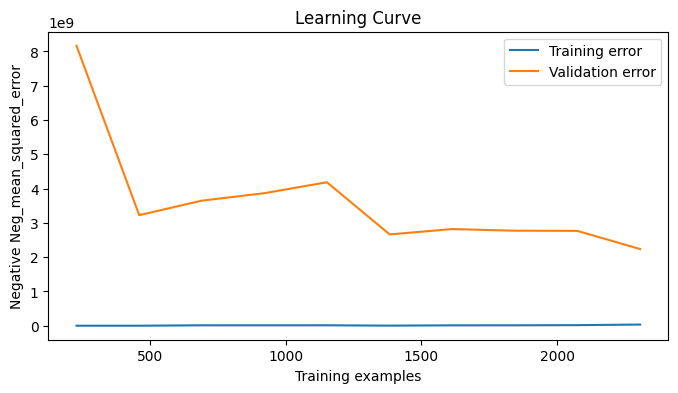

In [ ]:
# XGBoost
xgb = XGBRegressor()
xgb_params = {
    'learning_rate': [0.2, 0.3, 0.4, 0.5],
    'max_depth': np.arange(2, 10, step=1),
    'min_child_weight': np.arange(2, 10, step=1),
    'gamma': np.arange(0, 10, step=1),
}

xgb_model, xgb_train_sizes, xgb_train_scores, xgb_test_scores = perform_search(xgb, xgb_params, X_train, y_train, X_test, y_test)
xgb_feature_importances = xgb_model.feature_importances_

plot_learning_curve(xgb_model, X_train, y_train, cv=tscv)

In [ ]:
# XGBOOST:
# Best hyperparameters are: {'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 2}
# Best score is: -0.6546859284701437
# MSE: 465315475.8458952
# MAE: 5024.5214852318095
# MAPE: 0.46780280200750735

Best hyperparameters are: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 2}
Best score is: -0.6546859284701437
MSE: 465315475.8458952
MAE: 5024.5214852318095
MAPE: 0.46780280200750735


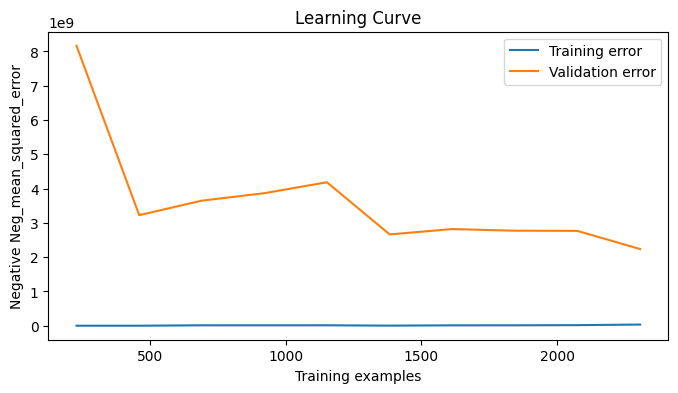

In [ ]:
# XGBoost: gridsearchcv
xgb = XGBRegressor()
xgb_params = {
    'learning_rate': [0.2, 0.3, 0.4, 0.5],
    'max_depth': np.arange(2, 10, step=1),
    'min_child_weight': np.arange(2, 10, step=1),
    'gamma': np.arange(0, 10, step=1),
}

xgb_model, xgb_train_sizes, xgb_train_scores, xgb_test_scores = perform_search(xgb, xgb_params, X_train, y_train, X_test, y_test, search_type='grid')
xgb_feature_importances = xgb_model.feature_importances_

plot_learning_curve(xgb_model, X_train, y_train, cv=tscv)


In [ ]:
## ENSEMBLE MODEL

pred_xgb = xgb_model.predict(X_test)
pred_rf = rf_model.predict(X_test)

weight_rf = 0
ensemble_df = pd.DataFrame(columns=['MSE', 'MAE', 'MAPE', 'Weight XGB', 'Weight RF'])
for i in range(0,10):
    weight_xgb = 1 - weight_rf
    
    final_pred = (weight_xgb * pred_xgb) + (weight_rf * pred_rf)
    
    ensemble_mse = mean_squared_error(y_test, final_pred)
    ensemble_mae = mean_absolute_error(y_test, final_pred)
    ensemble_mape = mean_absolute_percentage_error(y_test, final_pred)

    # store mse, mae and weights in a dataframe 
    ensemble_df.loc[i] = [f'{ensemble_mse:.2f}', ensemble_mae, ensemble_mape, weight_xgb, weight_rf]

    weight_rf += 0.1
    

ensemble_df.sort_values(by='MAPE', ascending=True, inplace=True)
ensemble_df

,MSE,MAE,MAPE,Weight XGB,Weight RF
0,465315475.85,5024.521485,0.467803,1.0,0.0
1,470698761.63,5403.795365,0.477778,0.9,0.1
2,482189110.46,5882.080249,0.492292,0.8,0.2
3,499786526.30,6398.859913,0.508912,0.7,0.3
4,523491000.78,6928.498727,0.527505,0.6,0.4
5,553302542.77,7477.864854,0.548433,0.5,0.5
6,589221142.71,8045.367713,0.572888,0.4,0.6
7,631246809.97,8620.887513,0.600013,0.3,0.7
8,679379541.85,9204.340600,0.629444,0.2,0.8
9,733619337.17,9808.134866,0.663781,0.1,0.9
